In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow import keras
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras import layers
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
dataset_dir = os.path.join(os.getcwd(), "CIFAKE")

img_height = 32
img_width = 32
batch_size = 500

# Load training and validation data
train, val = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "train"),
  validation_split=0.2,
  subset="both",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


In [3]:
# Load test data
test = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "test"),
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 20000 files belonging to 2 classes.


In [4]:
classes = train.class_names
classes

['FAKE', 'REAL']

In [5]:
# Preprocess images
def preprocess(x, y):
    return preprocess_input(x), y

train = train.map(preprocess)
val = val.map(preprocess)
test = test.map(preprocess)

In [6]:
# Load VGG16 and freeze weights
keras.backend.clear_session()

vgg = VGG16(include_top=False, input_shape=(img_height, img_width, 3))
vgg.trainable = False

In [7]:
# Build classifier around VGG16
model = Sequential([
    vgg,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(units=1024, activation="relu"),
    layers.Dense(units=1, activation="sigmoid")])

In [8]:
# Compile model
model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

In [9]:
model.summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  N          
                                                                            
 flatten (Flatten)           (None, 512)               0         Y          
                                                                            
 dropout (Dropout)           (None, 512)               0         Y          
                                                                            
 dense (Dense)               (None, 1024)              525312    Y          
                                                                            
 dense_1 (Dense)             (None, 1)                 1025      Y          
                                                                            
Total params: 15,241,025
Trainable params: 526,337
Non-t

In [10]:
# Train classifier
epochs = 8

history = model.fit(
  train,
  validation_data=val,
  epochs=epochs,
  verbose=0)

history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,1.474237,0.746025,0.751683,0.734500,0.482297,0.83350,0.885925,0.766151
1,0.694297,0.785575,0.791011,0.776016,0.366074,0.84335,0.888726,0.785522
2,0.490266,0.807813,0.813551,0.798474,0.321453,0.86385,0.873260,0.851722
3,0.416004,0.820312,0.825794,0.811729,0.339578,0.85395,0.925300,0.770544
4,0.385942,0.829675,0.835314,0.821108,0.328737,0.86350,0.918823,0.797903
5,0.372111,0.836725,0.841827,0.829111,0.311572,0.88045,0.893314,0.864503
6,0.359079,0.841762,0.846601,0.834638,0.309117,0.87920,0.909297,0.842836
7,0.351712,0.845662,0.849300,0.840315,0.304757,0.88690,0.887999,0.885871


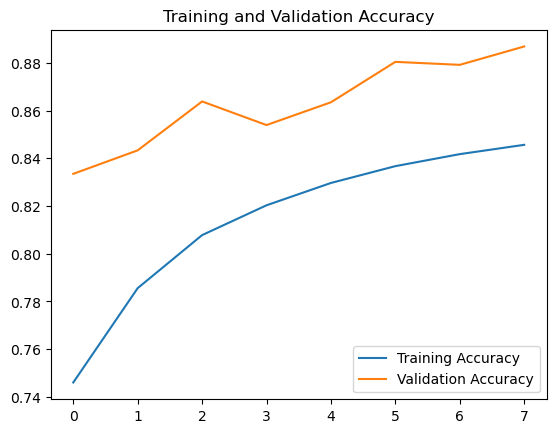

In [11]:
# Plot training and validation accuracy
plt.plot(range(epochs), history["accuracy"], label="Training Accuracy")
plt.plot(range(epochs), history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

In [12]:
# Unfreeze VGG
vgg.trainable = True

model.summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  Y          
                                                                            
 flatten (Flatten)           (None, 512)               0         Y          
                                                                            
 dropout (Dropout)           (None, 512)               0         Y          
                                                                            
 dense (Dense)               (None, 1024)              525312    Y          
                                                                            
 dense_1 (Dense)             (None, 1)                 1025      Y          
                                                                            
Total params: 15,241,025
Trainable params: 15,241,025
No

In [13]:
# Recompile model with low learning rate
model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(1e-4),
                metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

In [14]:
# Early stopping
es = EarlyStopping(monitor="val_accuracy",
                   patience=10,
                   restore_best_weights=True,
                   verbose=1)

In [15]:
# Fine-tune model
epochs = 40

history = model.fit(
  train,
  validation_data=val,
  epochs=epochs,
  verbose=0,
  callbacks=es)

history = pd.DataFrame(history.history)
display(history)

Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.236531,0.903562,0.909809,0.895861,0.143824,0.94665,0.970254,0.921717
1,0.115372,0.956500,0.960631,0.951982,0.117652,0.95375,0.976915,0.929606
2,0.082914,0.968912,0.971863,0.965762,0.116697,0.95590,0.948355,0.964453
3,0.054368,0.979988,0.981993,0.977892,0.114962,0.95825,0.939403,0.979830
4,0.039488,0.984963,0.986624,0.983244,0.108414,0.96365,0.957537,0.970444
5,0.029677,0.989250,0.990817,0.987645,0.110172,0.96280,0.954327,0.972242
6,0.023620,0.991838,0.992709,0.990947,0.106212,0.96585,0.966507,0.965252
7,0.017345,0.993800,0.994267,0.993322,0.130183,0.96060,0.979026,0.941488
8,0.019271,0.993450,0.994362,0.992522,0.137135,0.96590,0.959980,0.972441
9,0.017168,0.993850,0.994615,0.993072,0.109626,0.96370,0.951756,0.977034


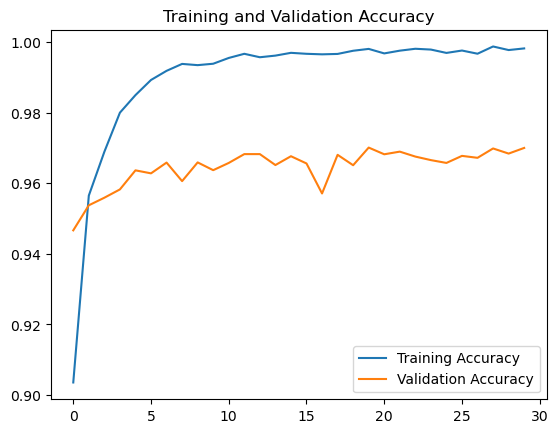

In [16]:
# Plot training and validation accuracy
plt.plot(range(len(history)), history["accuracy"], label="Training Accuracy")
plt.plot(range(len(history)), history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

In [17]:
# Evaluate on test data
model.evaluate(test, return_dict=True)

40/40 [==============================] - 5s 103ms/step - loss: 0.1448 - accuracy: 0.9680 - precision: 0.9692 - recall: 0.9667


{'loss': 0.14484086632728577,
 'accuracy': 0.9679999947547913,
 'precision': 0.969219982624054,
 'recall': 0.96670001745224}

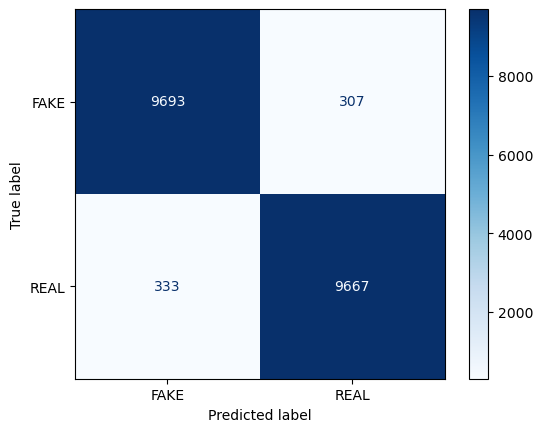

In [18]:
# Confusion matrix
test_predictions = np.array([])
test_labels = np.array([])
for x, y in test:
    test_predictions = np.append(test_predictions, model(x) > 0.5)
    test_labels = np.append(test_labels, y)
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, display_labels=classes, cmap="Blues");